#### 导入所需的包

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import nltk
import os
import gensim
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Doc2Vec
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


plt.rcParams['axes.unicode_minus'] = False 
plt.rc("font",family='FangSong')

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


#### 数据预处理

In [2]:
data = pd.read_excel("数据_Gpt与学者撰写_论文摘要.xlsx")
data.head()

,text,flag
0,"""十三五""时期我国公共图书馆发展成就突出,呈现出八大亮点:治理体系和治理能力现代化迈出了坚实...",-1
1,"""智慧图书馆""理念于2003年被首次提出,代表一种不受空间限制、可感知的移动图书馆服务,旨在...",-1
2,"“健康中国”战略的实施为我国公共图书馆健康信息服务提出了新的要求,公共图书馆的老年人健康信息...",-1
3,"《""十四五""公共文化服务体系建设规划》指明了公共文化服务体系建设的大方向、总目标,明确了主要...",-1
4,《“十四五”公共文化服务体系建设规划》是指导我国公共文化服务体系发展的重要文件，对于明确未来...,1


In [3]:
data.tail()

,text,flag
195,在新时代背景下，供给侧结构性改革对我国农村公共文化服务体系的振兴具有重要意义。本文从供给侧视...,1
196,在移动互联网时代，为满足用户多样化、个性化的阅读需求，本文提出了一种基于多源大数据驱动的移动...,1
197,智慧图书馆是新一代图书馆发展的重要趋势，其应用了先进的信息技术和创新理念，为用户提供更加高效...,1
198,"智慧图书馆正在从理论研究进入实践应用,理清智慧图书馆的发展脉络,认识智慧图书馆的内在本质,定...",-1
199,"中国情报学诞生于20世纪50年代,在发展过程中通过借鉴国内外相关学科的理论与方法,探索出许多...",-1


In [4]:
data.isnull().value_counts()
#缺失值查看

text   flag 
False  False    200
dtype: int64

In [5]:
labelData = pd.DataFrame(data['flag'].value_counts())
labelData

,flag
-1,100
1,100


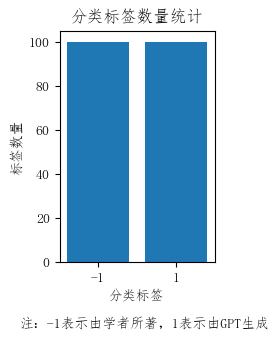

In [6]:
plt.figure(figsize=(2,3))
plt.bar(['-1','1'],labelData['flag'])
plt.xlabel("分类标签")
plt.ylabel("标签数量")
plt.title("分类标签数量统计")
plt.text(x=-1,y=-30,s="注：-1表示由学者所著，1表示由GPT生成")
plt.show()

In [7]:
stopwords = [line.rstrip() for line in open('hit_stopwords_marks.txt','r',encoding='utf-8')]
print(stopwords)

['———', '》），', '）÷（１－', '”，', '）、', '＝（', ':', '→', '℃', '&', '*', '一一', '~~~~', '’', '.', '『', '.一', './', '--', '』', '＝″', '【', '［＊］', '｝＞', '［⑤］］', '［①Ｄ］', 'ｃ］', 'ｎｇ昉', '＊', '//', '［', '］', '［②ｅ］', '［②ｇ］', '＝｛', '}', '，也', '‘', 'Ａ', '［①⑥］', '［②Ｂ］', '［①ａ］', '［④ａ］', '［①③］', '［③ｈ］', '③］', '１．', '－－', '［②ｂ］', '’‘', '×××', '［①⑧］', '０：２', '＝［', '［⑤ｂ］', '［②ｃ］', '［④ｂ］', '［②③］', '［③ａ］', '［④ｃ］', '［①⑤］', '［①⑦］', '［①ｇ］', '∈［', '［①⑨］', '［①④］', '［①ｃ］', '［②ｆ］', '［②⑧］', '［②①］', '［①Ｃ］', '［③ｃ］', '［③ｇ］', '［②⑤］', '［②②］', '一.', '［①ｈ］', '.数', '［］', '［①Ｂ］', '数/', '［①ｉ］', '［③ｅ］', '［①①］', '［④ｄ］', '［④ｅ］', '［③ｂ］', '［⑤ａ］', '［①Ａ］', '［②⑧］', '［②⑦］', '［①ｄ］', '［②ｊ］', '〕〔', '］［', '://', '′∈', '［②④', '［⑤ｅ］', '１２％', 'ｂ］', '...', '...................', '…………………………………………………③', 'ＺＸＦＩＴＬ', '［③Ｆ］', '」', '［①ｏ］', '］∧′＝［', '∪φ∈', '′｜', '｛－', '②ｃ', '｝', '［③①］', 'Ｒ．Ｌ．', '［①Ｅ］', 'Ψ', '－［＊］－', '↑', '.日', '［②ｄ］', '［②', '［②⑦］', '［②②］', '［③ｅ］', '［①ｉ］', '［①Ｂ］', '［①ｈ］', '［①ｄ］', '［①ｇ］', '［①②］', '［②ａ］', 'ｆ］', '［⑩］', 'ａ］', '［①ｅ］', '［②ｈ］',

In [8]:
def txt_cut(juzi):
    lis=[w for w in jieba.lcut(juzi) if w not in stopwords]
    return (" ").join(lis)
data['text_cut']=data['text'].astype('str').apply(txt_cut)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 1.122 seconds.
Prefix dict has been built successfully.


In [9]:
data.head()

,text,flag,text_cut
0,"""十三五""时期我国公共图书馆发展成就突出,呈现出八大亮点:治理体系和治理能力现代化迈出了坚实...",-1,十三 五 时期 我国 公共 图书馆 发展 成就 突出 呈现出 八大 亮点 治理 体系 和 治...
1,"""智慧图书馆""理念于2003年被首次提出,代表一种不受空间限制、可感知的移动图书馆服务,旨在...",-1,智慧 图书馆 理念 于 2003 年 被 首次 提出 代表 一种 不 受 空间 限制 可 感...
2,"“健康中国”战略的实施为我国公共图书馆健康信息服务提出了新的要求,公共图书馆的老年人健康信息...",-1,健康 中国 战略 的 实施 为 我国 公共 图书馆 健康 信息 服务 提出 了 新 的 要求...
3,"《""十四五""公共文化服务体系建设规划》指明了公共文化服务体系建设的大方向、总目标,明确了主要...",-1,十四五 公共 文化 服务体系 建设 规划 指明 了 公共 文化 服务体系 建设 的 大方向 ...
4,《“十四五”公共文化服务体系建设规划》是指导我国公共文化服务体系发展的重要文件，对于明确未来...,1,十四五 公共 文化 服务体系 建设 规划 是 指导 我国 公共 文化 服务体系 发展 的 重...


## 文本特征提取
### TF-IDF方法
#### 分别检视AI和学者所写摘要的词频特征、TF-IDF排序

In [10]:
tf_vectorizer1 = TfidfVectorizer()
tf_vectorizer2 = TfidfVectorizer()
X_C = tf_vectorizer1.fit_transform(data[data['flag'] == 1].text_cut)
X_H = tf_vectorizer2.fit_transform(data[data['flag'] == -1].text_cut)
feature_names_C = tf_vectorizer1.get_feature_names_out()  # 获取TF-IDF向量化器的词汇表
feature_names_H = tf_vectorizer2.get_feature_names_out()  # 获取TF-IDF向量化器的词汇表
tfidf_values_C = X_C.toarray()
tfidf_values_H = X_H.toarray() # 将TF-IDF特征矩阵从稀疏矩阵转换为常规数组，方便查看和操作

In [11]:
print(X_C.shape,X_H.shape)
print(feature_names_C,feature_names_H)
print(feature_names_C.shape,feature_names_H.shape)
print(tfidf_values_C.shape,tfidf_values_H.shape)

(100, 1272) (100, 2278)
['2020' '2035' '267' ... '高质量' '高速' '鸿沟'] ['10' '100' '12' ... '鲜明' '鲜有' '鼓励']
(1272,) (2278,)
(100, 1272) (100, 2278)


In [12]:
# 从转换器中提取词汇和对应的 TF-IDF 值
data_C = {'word': tf_vectorizer1.get_feature_names_out(),
        'frequency':np.count_nonzero(X_C.toarray(), axis=0),
        'tfidf': X_C.toarray().sum(axis=0).tolist(),
        'weight': X_C.mean(axis=0).A.flatten(),}
data_C = pd.DataFrame(data_C).sort_values(by="frequency" ,ascending=False,ignore_index=True)
data_C_tfidf = pd.DataFrame(data_C).sort_values(by="tfidf" ,ascending=False,ignore_index=True) 

data_H = {'word': tf_vectorizer2.get_feature_names_out(),
        'frequency':np.count_nonzero(X_H.toarray(), axis=0),
         'tfidf': X_H.toarray().sum(axis=0).tolist(),
        'weight': X_H.mean(axis=0).A.flatten(),}
data_H = pd.DataFrame(data_H).sort_values(by="frequency" ,ascending=False,ignore_index=True) 
data_H_tfidf = pd.DataFrame(data_H).sort_values(by="tfidf" ,ascending=False,ignore_index=True) 

data_C.head(10)

,word,frequency,tfidf,weight
0,提出,88,2.412638,0.024126
1,首先,84,1.819072,0.018191
2,分析,84,2.710262,0.027103
3,提供,82,2.331393,0.023314
4,本文,79,2.853655,0.028537
5,建议,79,1.962165,0.019622
6,最后,75,1.802119,0.018021
7,发展,74,5.298942,0.052989
8,探讨,74,2.286740,0.022867
9,包括,71,2.172210,0.021722


In [13]:
data_H.head(10)

,word,frequency,tfidf,weight
0,图书馆,65,10.249763,0.102498
1,发展,62,4.788245,0.047882
2,服务,56,6.164865,0.061649
3,提出,41,1.610520,0.016105
4,分析,39,1.919634,0.019196
5,构建,36,1.992899,0.019929
6,研究,35,2.258986,0.022590
7,建设,35,3.277793,0.032778
8,理论,33,2.069709,0.020697
9,文化,33,6.375098,0.063751


In [14]:
data_C_tfidf.head(10)

,word,frequency,tfidf,weight
0,图书馆,61,12.158025,0.121580
1,公共,32,7.090517,0.070905
2,智慧,15,5.792685,0.057927
3,服务,54,5.658609,0.056586
4,发展,74,5.298942,0.052989
5,文化,31,5.265371,0.052654
6,阅读,12,4.441007,0.044410
7,研究,70,4.397942,0.043979
8,高校,14,3.962898,0.039629
9,数据,30,3.790457,0.037905


In [15]:
data_H_tfidf.head(10)

,word,frequency,tfidf,weight
0,图书馆,65,10.249763,0.102498
1,公共,32,7.206517,0.072065
2,文化,33,6.375098,0.063751
3,服务,56,6.164865,0.061649
4,智慧,25,5.618725,0.056187
5,发展,62,4.788245,0.047882
6,数据,29,4.022289,0.040223
7,阅读,14,3.748958,0.037490
8,资源,27,3.704714,0.037047
9,建设,35,3.277793,0.032778


##### AI-词频特征

In [16]:
#打印词频统计表
data_list_C = list(zip(data_C['word'], data_C['frequency']))
data_list_C = sorted(data_list_C, key=lambda x: x[1], reverse=True)
print(data_list_C)

[('提出', 88), ('首先', 84), ('分析', 84), ('提供', 82), ('本文', 79), ('建议', 79), ('最后', 75), ('发展', 74), ('探讨', 74), ('包括', 71), ('研究', 70), ('方面', 63), ('图书馆', 61), ('接着', 59), ('挑战', 57), ('实践', 55), ('策略', 54), ('服务', 54), ('通过', 52), ('针对', 52), ('旨在', 51), ('进行', 46), ('其次', 45), ('创新', 43), ('面临', 43), ('技术', 42), ('参考', 37), ('加强', 36), ('文章', 35), ('重要', 35), ('资源', 34), ('作用', 32), ('公共', 32), ('文化', 31), ('问题', 30), ('数据', 30), ('建设', 30), ('应用', 29), ('优化', 29), ('背景', 29), ('推动', 29), ('未来', 28), ('及其', 28), ('需求', 27), ('政策', 27), ('以期', 26), ('提升', 26), ('意义', 26), ('提高', 26), ('随着', 26), ('支持', 26), ('我国', 25), ('合作', 25), ('价值', 25), ('构建', 25), ('理论', 25), ('阐述', 24), ('案例', 24), ('梳理', 24), ('强调', 23), ('相应', 23), ('具有', 23), ('模式', 23), ('领域', 23), ('此基础', 23), ('此外', 23), ('知识', 22), ('影响', 21), ('作为', 21), ('内容', 21), ('方法', 20), ('机遇', 20), ('社会', 20), ('路径', 20), ('关注', 20), ('一系列', 19), ('结合', 19), ('发现', 19), ('有益', 19), ('数字化', 19), ('促进', 18), ('人才培养', 18), ('以及', 18

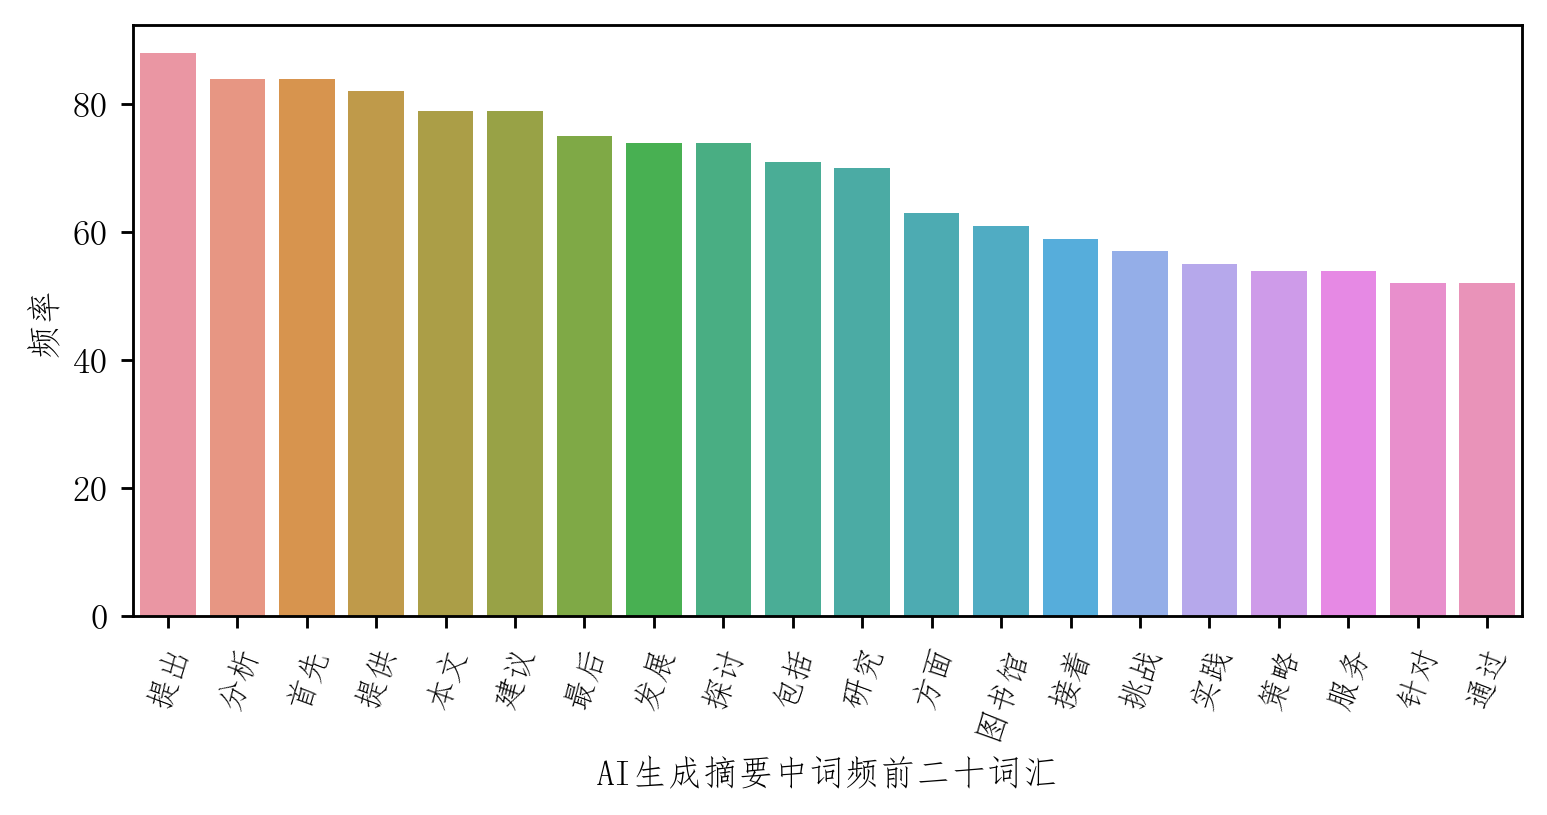

In [17]:
#绘制词频统计图-AI
df_C=pd.DataFrame(data_C).sort_values(by="frequency" ,ascending=False,ignore_index=True) 
plt.figure(figsize=(7,3),dpi=256)
sns.barplot(x=df_C['word'][:20],y=df_C['frequency'][:20])
plt.xticks(rotation=70,fontsize=9) 
plt.ylabel('频率')
plt.xlabel('AI生成摘要中词频前二十词汇')
plt.show()

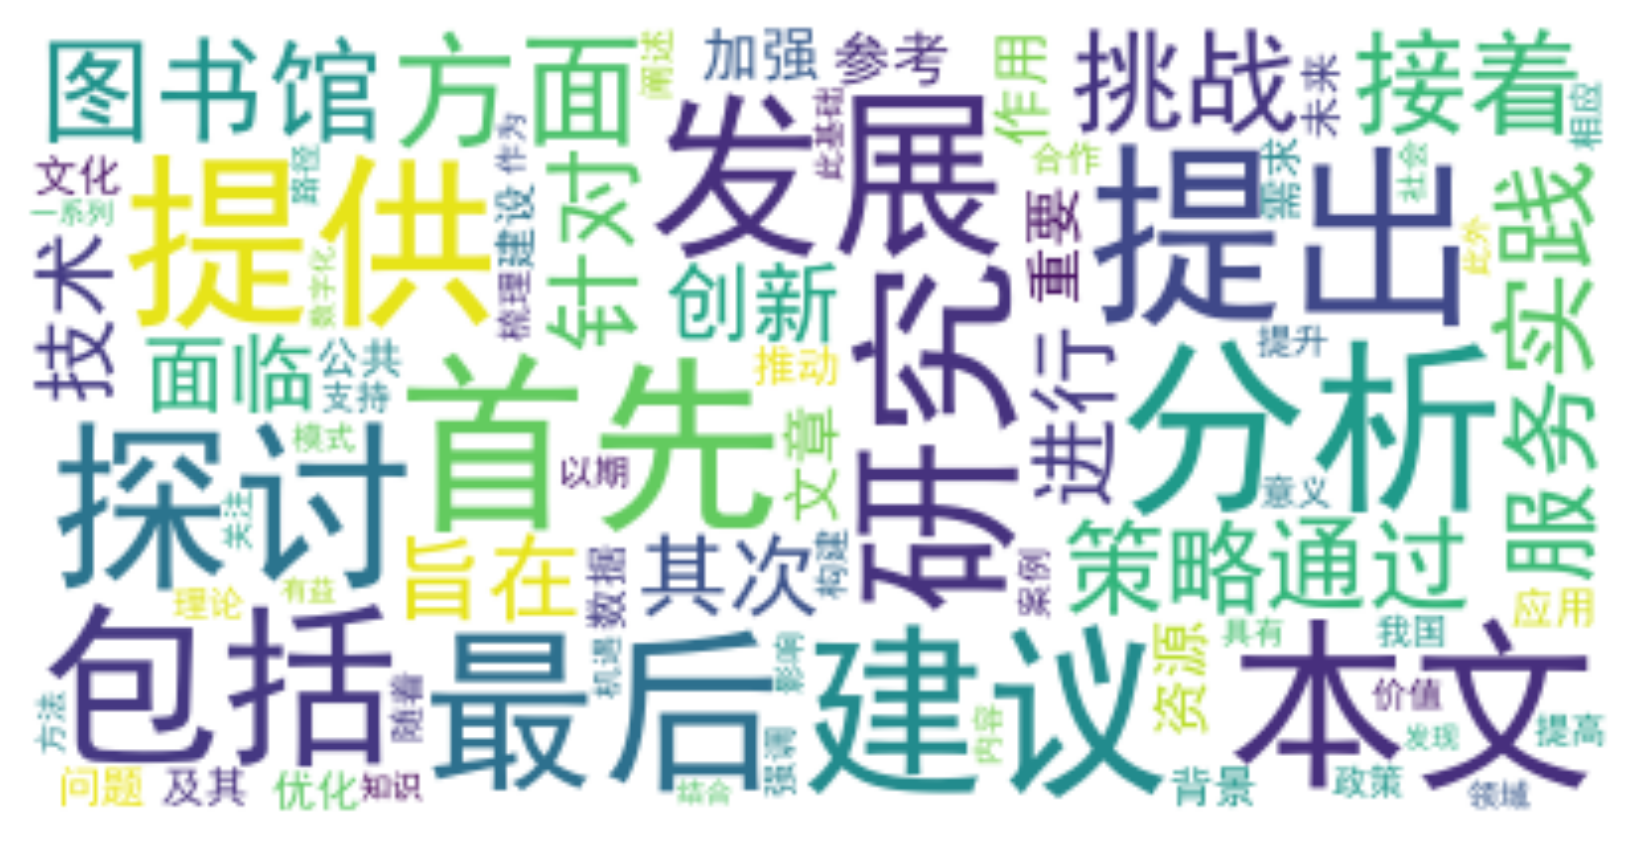

In [18]:
#绘制词云图-AI
wordcloud = WordCloud(font_path='simhei.ttf', background_color='white', 
                      max_words=80,       
                      max_font_size=50)   
wordcloud = wordcloud.generate_from_frequencies(dict(data_list_C))
# Display the word cloud
plt.figure(figsize=(8, 5),dpi=256)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##### AI-TF-IDF

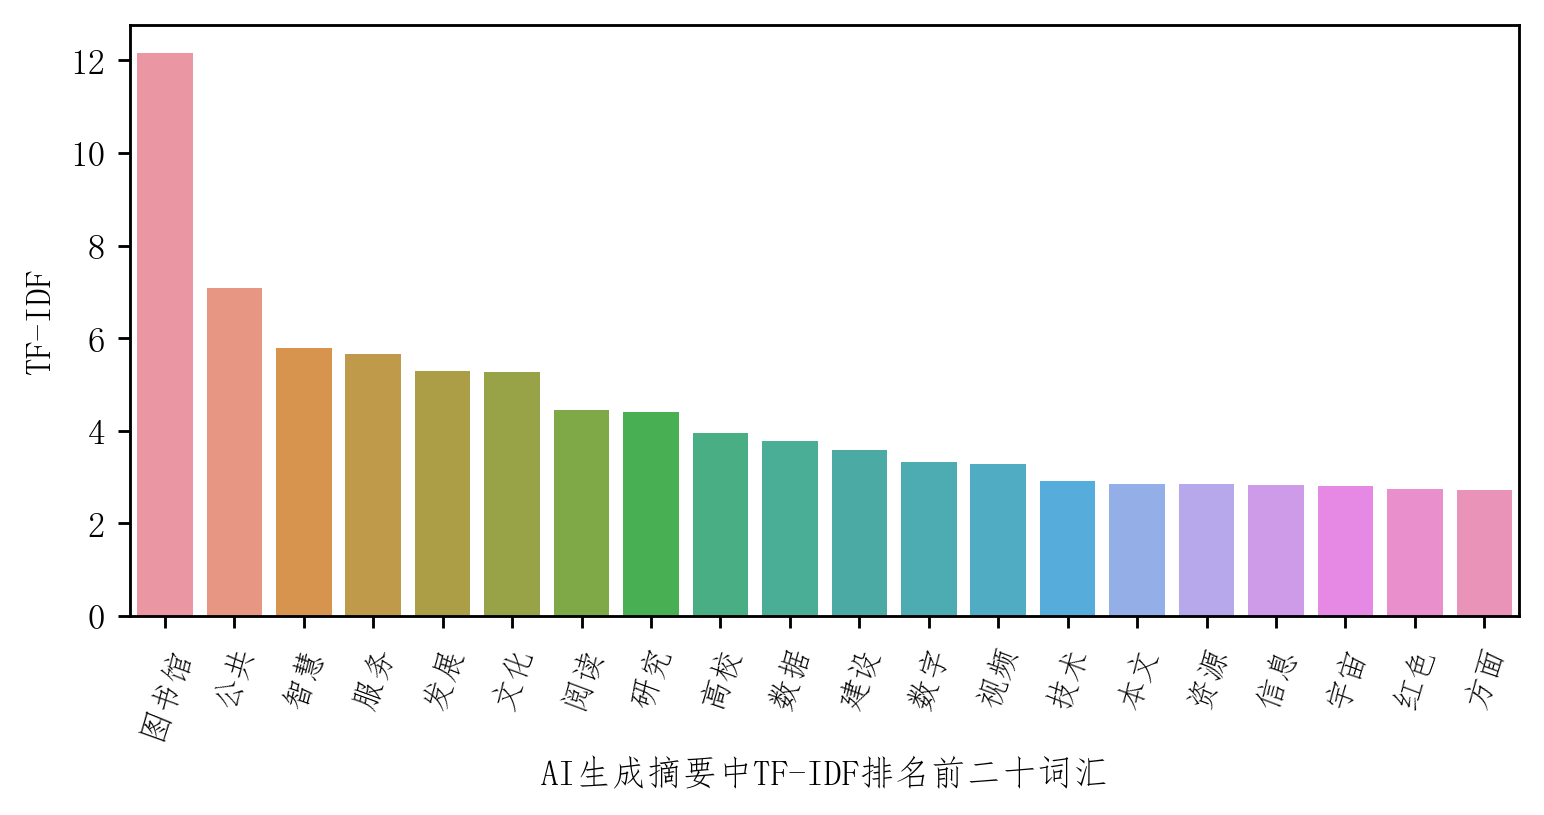

In [19]:
#绘制TF-IDF排序图-AI
df_C_tfidf=pd.DataFrame(data_C).sort_values(by="tfidf" ,ascending=False,ignore_index=True) 
plt.figure(figsize=(7,3),dpi=256)
sns.barplot(x=df_C_tfidf['word'][:20],y=df_C_tfidf['tfidf'][:20])
plt.xticks(rotation=70,fontsize=9) 
plt.ylabel('TF-IDF')
plt.xlabel('AI生成摘要中TF-IDF排名前二十词汇')
plt.show()

##### 学者-词频特征

In [20]:
#打印词频统计表
data_list_H = list(zip(data_H['word'], data_H['frequency']))
data_list_H = sorted(data_list_H, key=lambda x: x[1], reverse=True)
print(data_list_H)

[('图书馆', 65), ('发展', 62), ('服务', 56), ('提出', 41), ('分析', 39), ('构建', 36), ('研究', 35), ('建设', 35), ('理论', 33), ('文化', 33), ('公共', 32), ('进行', 32), ('创新', 30), ('数据', 29), ('通过', 29), ('方面', 28), ('文章', 28), ('资源', 27), ('技术', 27), ('提供', 26), ('我国', 25), ('基于', 25), ('问题', 25), ('智慧', 25), ('体系', 24), ('重要', 24), ('实践', 23), ('内容', 23), ('实现', 22), ('推动', 22), ('需求', 22), ('数字', 22), ('融合', 21), ('基础', 20), ('空间', 20), ('提升', 20), ('信息', 19), ('社会', 19), ('平台', 19), ('探索', 18), ('参考文献', 18), ('存在', 18), ('本文', 17), ('以及', 17), ('形成', 17), ('促进', 17), ('文献', 17), ('知识', 17), ('价值', 16), ('框架', 16), ('成为', 16), ('理念', 16), ('路径', 16), ('主要', 16), ('相关', 16), ('结合', 16), ('高校', 16), ('深度', 15), ('模式', 15), ('推进', 15), ('应用', 15), ('系统', 15), ('管理', 15), ('开展', 14), ('方法', 14), ('转型', 14), ('国家', 14), ('阅读', 14), ('用户', 14), ('模型', 14), ('时代', 14), ('推广', 14), ('策略', 13), ('基本', 13), ('服务体系', 13), ('方向', 13), ('中国', 13), ('具有', 13), ('探讨', 13), ('要素', 13), ('加强', 12), ('环境', 12), ('核心', 12)

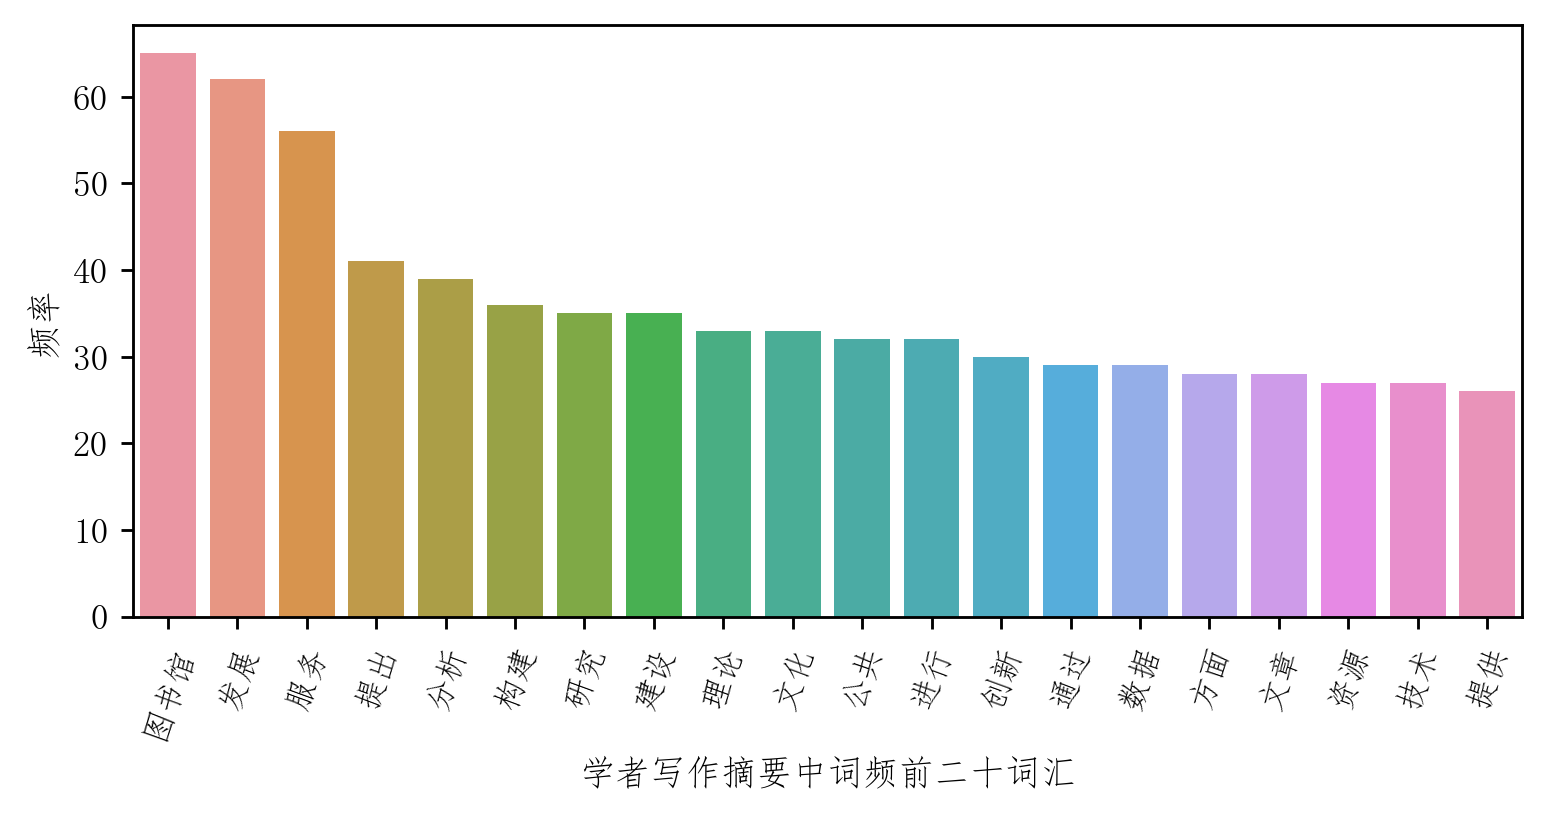

In [21]:
#绘制词频统计图-学者
df_H=pd.DataFrame(data_H).sort_values(by="frequency" ,ascending=False,ignore_index=True) 
plt.figure(figsize=(7,3),dpi=256)
sns.barplot(x=df_H['word'][:20],y=df_H['frequency'][:20])
plt.xticks(rotation=70,fontsize=9) 
plt.ylabel('频率')
plt.xlabel('学者写作摘要中词频前二十词汇')
plt.show()

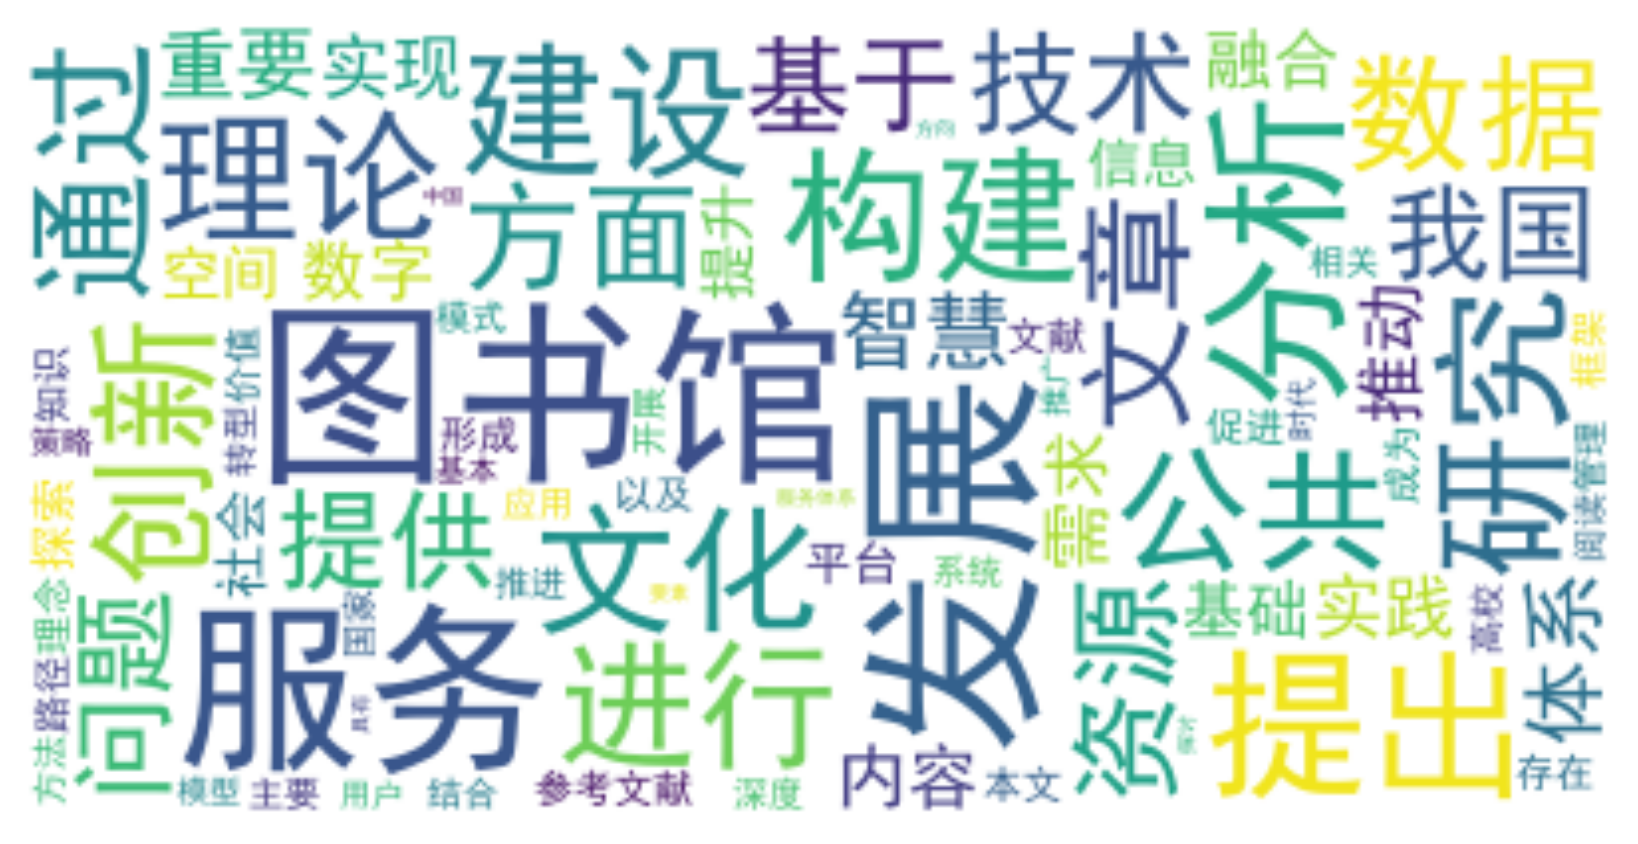

In [22]:
#绘制词云图-学者
wordcloud = WordCloud(font_path='simhei.ttf', background_color='white', 
                      max_words=80,       
                      max_font_size=50)   
wordcloud = wordcloud.generate_from_frequencies(dict(data_list_H))
# Display the word cloud
plt.figure(figsize=(8, 5),dpi=256)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##### 学者-TF-IDF

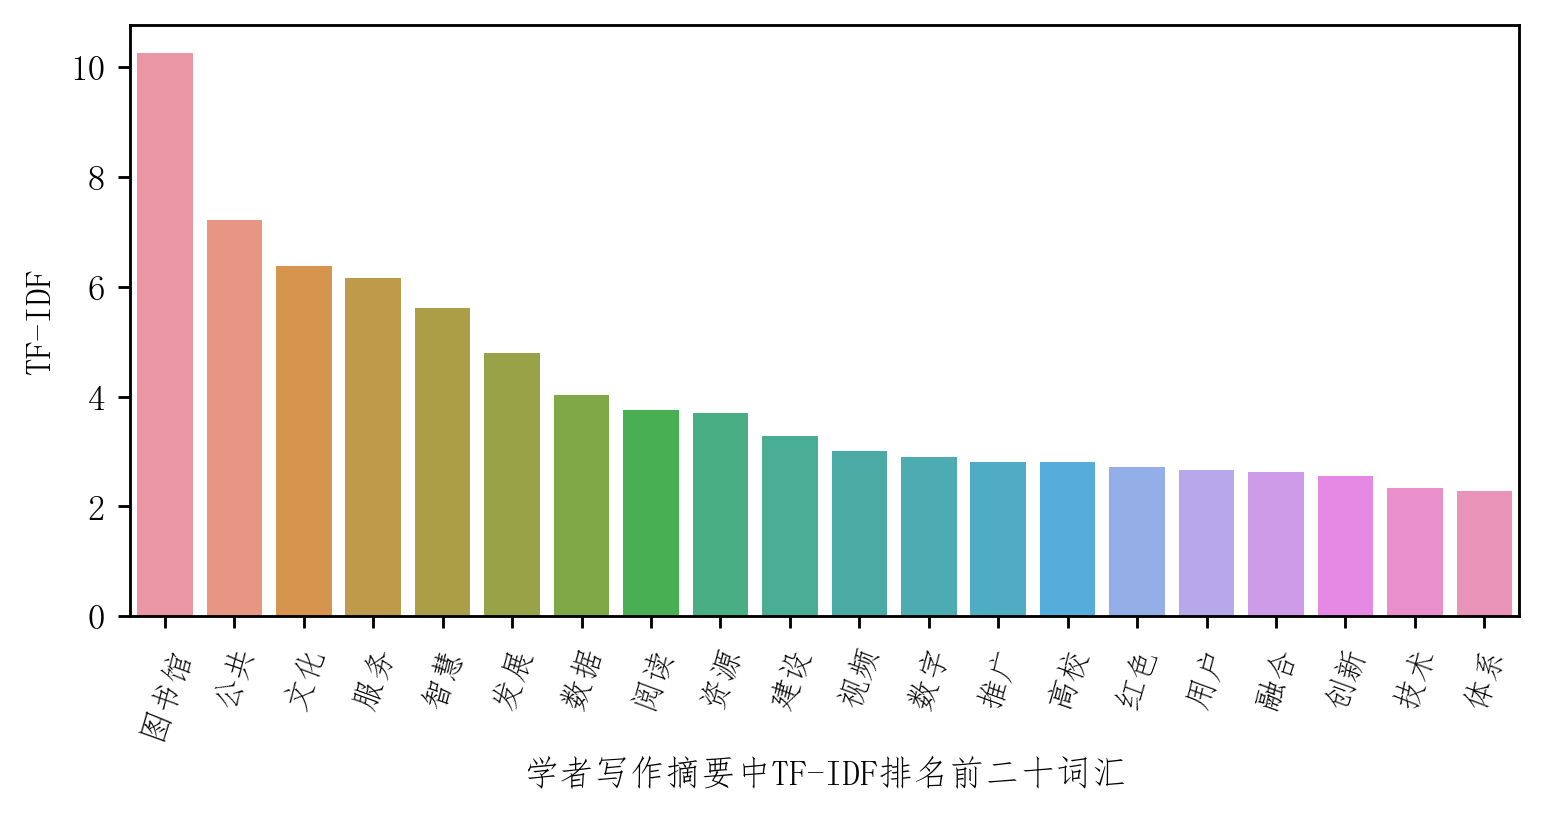

In [23]:
#绘制TF-IDF排序图-学者
df_H_tfidf=pd.DataFrame(data_H).sort_values(by="tfidf" ,ascending=False,ignore_index=True) 
plt.figure(figsize=(7,3),dpi=256)
sns.barplot(x=df_H_tfidf['word'][:20],y=df_H_tfidf['tfidf'][:20])
plt.xticks(rotation=70,fontsize=9) 
plt.ylabel('TF-IDF')
plt.xlabel('学者写作摘要中TF-IDF排名前二十词汇')
plt.show()

#### 生成用于分类算法的TF-IDF词频特征

In [24]:
X_classification = data['text_cut']
y_classification = data['flag']
vectorizer = TfidfVectorizer(max_features=5000,max_df=0.1,min_df=3)
X_classification = vectorizer.fit_transform(X_classification)
X_classification.shape

(200, 735)

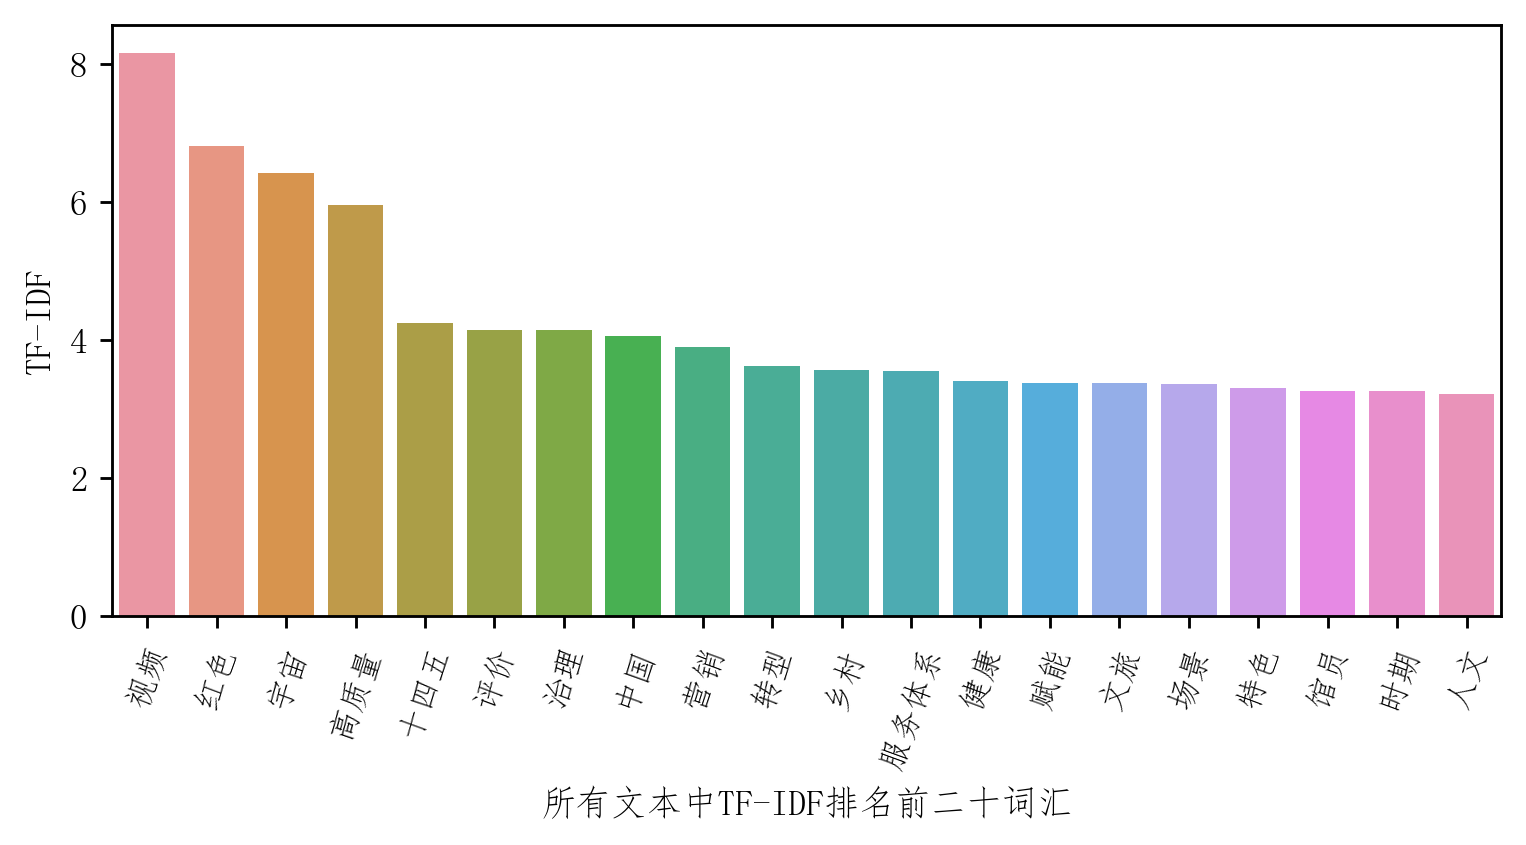

In [25]:
data_classification = {'word': vectorizer.get_feature_names_out(),
        'tfidf': X_classification.toarray().sum(axis=0).tolist()}
df_classification = pd.DataFrame(data_classification).sort_values(by="tfidf" ,ascending=False,ignore_index=True) 
df_classification.head(20)

plt.figure(figsize=(7,3),dpi=256)
sns.barplot(x=df_classification['word'][:20],y=df_classification['tfidf'][:20])
plt.xticks(rotation=70,fontsize=9) 
plt.ylabel('TF-IDF')
plt.xlabel('所有文本中TF-IDF排名前二十词汇')
plt.show()

## 机器学习分类算法 效果对比

### 基本效果对比

In [26]:
X_train, X_test, y_train, y_test =train_test_split(X_classification,y_classification,test_size=0.2,stratify=y_classification,random_state = 0)
#可以检查一下划分后数据形状
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((160, 735), (40, 735), (160,), (40,))

In [47]:
y_test

73    -1
70     1
175   -1
14    -1
90    -1
33     1
109    1
149   -1
45     1
108    1
74     1
65     1
20     1
91    -1
64    -1
99    -1
94    -1
129    1
102   -1
125    1
168   -1
30     1
31     1
148   -1
12     1
101   -1
44     1
11     1
192   -1
4      1
119    1
113    1
151   -1
52    -1
187    1
176   -1
141   -1
170   -1
155   -1
61     1
Name: flag, dtype: int64

In [27]:
#逻辑回归
model1 = LogisticRegression()
#支持向量机
model2 = SVC(kernel="rbf", random_state=77, probability=True) # 使用RBF核，设置随机数种子为77，并启用概率估计
#GBDT
model3 = GradientBoostingClassifier()
#随机森林
model4 = RandomForestClassifier()

 
model_list=[model1,model2,model3,model4]
model_name=['逻辑回归','支持向量机','GBDT','随机森林']

In [57]:
# 自定义一下训练和评价函数

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # 训练模型
    model.fit(X_train, y_train)
    # 计算准确率
    accuracy = model.score(X_test, y_test)
    print(f'{model_name}方法在测试集的准确率为{round(accuracy, 3)}')
    
    # 计算混淆矩阵
    cm = confusion_matrix(y_test, model.predict(X_test))
    print(f'混淆矩阵：\n{cm}')
    
    # 绘制混淆矩阵热力图
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AI生成', '学者写作'])
    # 参数confusion_matrix指定混淆矩阵，这里是cm
    # 参数display_labels指定混淆矩阵中显示的标签
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    #输出样本与预测值
    fault=[]
    print(model_name,"错误样本：")
    y_pred = model.predict(X_test)
    for i in range(len(y_pred)):
        if y_pred[i] != y_test.values[i]:
            fault.append(y_test.keys()[i])
    
    return accuracy,fault

In [56]:
y_test.keys()[0]

73

逻辑回归方法在测试集的准确率为0.6
混淆矩阵：
[[13  7]
 [ 9 11]]


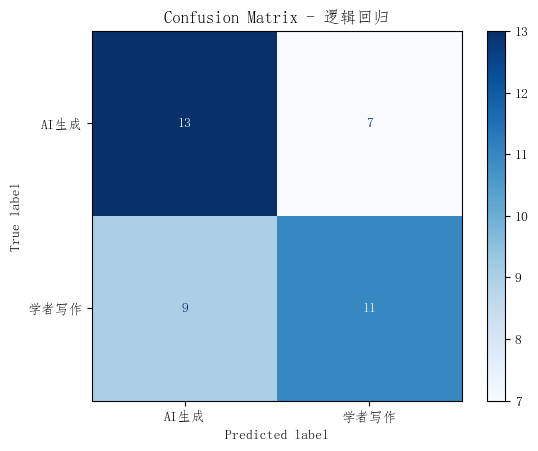

逻辑回归 错误样本：
支持向量机方法在测试集的准确率为0.475
混淆矩阵：
[[13  7]
 [14  6]]


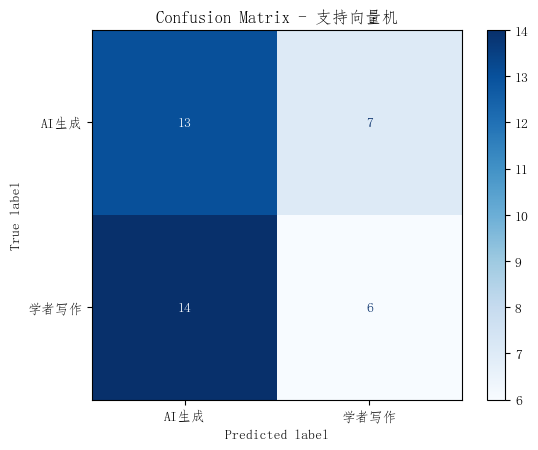

支持向量机 错误样本：
GBDT方法在测试集的准确率为0.75
混淆矩阵：
[[15  5]
 [ 5 15]]


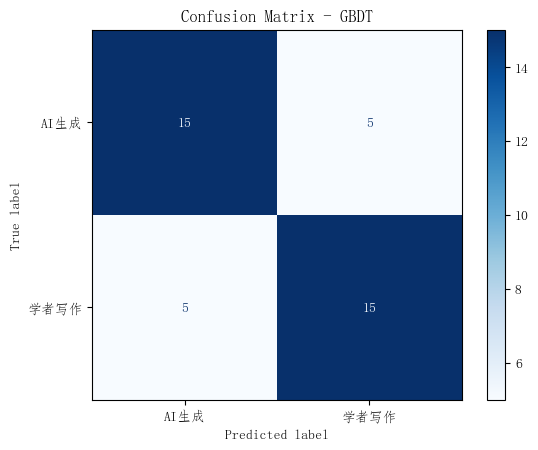

GBDT 错误样本：
随机森林方法在测试集的准确率为0.9
混淆矩阵：
[[19  1]
 [ 3 17]]


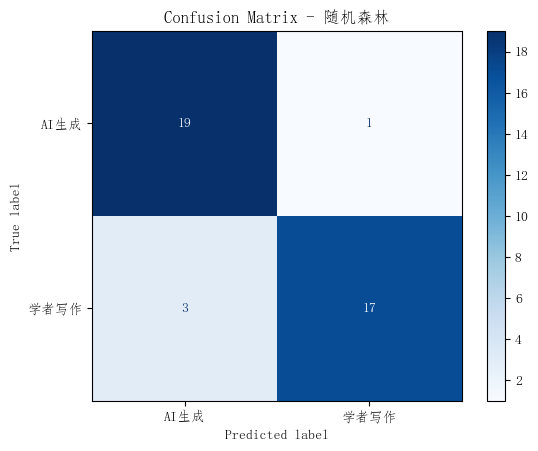

随机森林 错误样本：


In [58]:
accuracys=[]
Fault = []
for model, name in zip(model_list, model_name):
    accuracy,fault =evaluate_model(model, X_train, X_test, y_train, y_test, name)
    accuracys.append(accuracy)
    Fault.append(fault)

In [30]:
accuracys

[0.6, 0.475, 0.75, 0.9]

In [59]:
Fault

[[175, 14, 109, 149, 45, 74, 65, 20, 64, 99, 129, 102, 125, 101, 119, 61],
 [70,
  175,
  14,
  109,
  149,
  45,
  108,
  74,
  65,
  20,
  64,
  99,
  129,
  102,
  125,
  31,
  101,
  44,
  119,
  187,
  61],
 [70, 175, 108, 74, 99, 148, 12, 170, 155, 61],
 [74, 99, 31, 61]]

In [83]:
falutdata1 = pd.DataFrame()
falutdata2 = pd.DataFrame()
falutdata3 = pd.DataFrame()
falutdata4 = pd.DataFrame()
for j in Fault[0]:
    print(data.loc[j,"flag"],data.loc[j,"text"])


-1 运用恰当、有效的策略吸引、培养和留住年轻馆员,是高校图书馆保持核心竞争力的关键。近十年来,就如何建设一支高素质的年轻馆员队伍,上海交通大学图书馆在人才招聘、岗位聘任、薪酬管理、职务晋升、馆员培训、国际交流和考核评估等方面进行了系统性的探索,并就"十四五"期间大学图书馆如何培养年轻馆员人才队伍进行了思考。
-1 本文收集三大国际权威标准组织ISO、IEC、ITU-T发布的标准文件中关于数据治理的各类定义,对数据治理的核心概念及其关系进行解构分析。基于数据治理的核心概念、概念关系及其视角进一步选择19个国际标准进行内容映射分析,构建出面向数字政府、数字经济和数字社会的数据治理标准化协同路径分析模型。依据该模型从多维度(数字政府、数字经济、数字社会)和多层级(宏观、中观和微观)归纳了美国和欧盟数据治理标准化协同路径的实施方案。本研究对于我国数据治理理论与实践具有以下现实价值和实践意义:推动我国积极参与数据治理领域国际规则和标准的制定,促进数据治理国家标准与国际标准的接轨;建立全视域的数据治理标准体系,构建基于"数字政府、数字经济、数字社会"的多场景、多层级的数据治理标准化协同路径及实施方案;构建数字治理标准化协同国家战略,促进多元主体共同参与数据治理标准建设。
1 随着抖音平台的兴起，短视频成为信息传播的新趋势。本文通过调查我国省级公共图书馆在抖音平台的运营现状，旨在揭示图书馆在抖音短视频领域的发展现状及存在的问题。本研究采用网络爬虫技术，收集了大量省级公共图书馆抖音账号的数据，并对其运营情况、内容特点、用户互动等方面进行了详细分析。研究发现，虽然我国省级公共图书馆已经积极拓展抖音短视频领域，但在内容创新、互动体验、传播效果等方面仍存在一定的不足。针对这些问题，本文提出了相应的改进建议，以期为我国省级公共图书馆在抖音平台上的运营提供参考。
-1 图书馆向智慧转型升级需要开放的理念、共享的平台和先进的技术。云瀚是基于目前国际最先进的开源技术和云原生架构,采用自主可控的产品路线,由中国图书馆界前沿学术研究力量和领先技术力量自主研发的下一代图书馆服务中文平台。云瀚是FOLIO的中国化和本土化,它既是下一代图书馆服务平台,又是一套取代传统图书馆集成管理系统的应用组件,同时也是一个以开放理念运行的开源社区。云瀚将以智慧图书馆技术应用联盟为依托,探索开放的社区运作模式,建立产业

In [84]:
for j in Fault[1]:
    print(data.loc[j,"flag"],data.loc[j,"text"])


1 公共图书馆空间建设对于满足读者需求和提升图书馆服务质量具有重要作用。本文从文化场景理论视角出发，对公共图书馆空间建设进行深入研究。首先，阐述了文化场景理论的基本概念及其在公共图书馆空间建设中的应用价值。其次，结合国内外公共图书馆的实践案例，探讨了文化场景理论在公共图书馆空间建设中的具体表现，包括空间布局、设计元素、功能设置等方面。研究发现，基于文化场景理论的公共图书馆空间建设能够创造更具吸引力、舒适性和包容性的阅读环境，有助于提升图书馆服务质量和满足读者多元化需求。最后，针对当前公共图书馆空间建设所面临的挑战，提出了相应的策略建议，包括注重文化场景的营造、强化人文关怀、促进空间功能融合、加强技术创新等，以期为公共图书馆空间建设提供理论支持和实践指导。
-1 运用恰当、有效的策略吸引、培养和留住年轻馆员,是高校图书馆保持核心竞争力的关键。近十年来,就如何建设一支高素质的年轻馆员队伍,上海交通大学图书馆在人才招聘、岗位聘任、薪酬管理、职务晋升、馆员培训、国际交流和考核评估等方面进行了系统性的探索,并就"十四五"期间大学图书馆如何培养年轻馆员人才队伍进行了思考。
-1 本文收集三大国际权威标准组织ISO、IEC、ITU-T发布的标准文件中关于数据治理的各类定义,对数据治理的核心概念及其关系进行解构分析。基于数据治理的核心概念、概念关系及其视角进一步选择19个国际标准进行内容映射分析,构建出面向数字政府、数字经济和数字社会的数据治理标准化协同路径分析模型。依据该模型从多维度(数字政府、数字经济、数字社会)和多层级(宏观、中观和微观)归纳了美国和欧盟数据治理标准化协同路径的实施方案。本研究对于我国数据治理理论与实践具有以下现实价值和实践意义:推动我国积极参与数据治理领域国际规则和标准的制定,促进数据治理国家标准与国际标准的接轨;建立全视域的数据治理标准体系,构建基于"数字政府、数字经济、数字社会"的多场景、多层级的数据治理标准化协同路径及实施方案;构建数字治理标准化协同国家战略,促进多元主体共同参与数据治理标准建设。
1 随着抖音平台的兴起，短视频成为信息传播的新趋势。本文通过调查我国省级公共图书馆在抖音平台的运营现状，旨在揭示图书馆在抖音短视频领域的发展现状及存在的问题。本研究采用网络爬虫技术，收集了大量省级公共图书馆抖音账号的数据，并对其运营情况、内容特点、用户互动等

In [85]:
for j in Fault[2]:
    print(data.loc[j,"flag"],data.loc[j,"text"])


1 公共图书馆空间建设对于满足读者需求和提升图书馆服务质量具有重要作用。本文从文化场景理论视角出发，对公共图书馆空间建设进行深入研究。首先，阐述了文化场景理论的基本概念及其在公共图书馆空间建设中的应用价值。其次，结合国内外公共图书馆的实践案例，探讨了文化场景理论在公共图书馆空间建设中的具体表现，包括空间布局、设计元素、功能设置等方面。研究发现，基于文化场景理论的公共图书馆空间建设能够创造更具吸引力、舒适性和包容性的阅读环境，有助于提升图书馆服务质量和满足读者多元化需求。最后，针对当前公共图书馆空间建设所面临的挑战，提出了相应的策略建议，包括注重文化场景的营造、强化人文关怀、促进空间功能融合、加强技术创新等，以期为公共图书馆空间建设提供理论支持和实践指导。
-1 运用恰当、有效的策略吸引、培养和留住年轻馆员,是高校图书馆保持核心竞争力的关键。近十年来,就如何建设一支高素质的年轻馆员队伍,上海交通大学图书馆在人才招聘、岗位聘任、薪酬管理、职务晋升、馆员培训、国际交流和考核评估等方面进行了系统性的探索,并就"十四五"期间大学图书馆如何培养年轻馆员人才队伍进行了思考。
1 随着大数据和人工智能技术的发展，图书馆智慧参考咨询服务已逐渐成为当代图书馆服务的发展方向。本文以用户画像为基础，对图书馆智慧参考咨询服务模式进行深入研究。首先，阐述了用户画像的基本概念及其在图书馆智慧参考咨询服务中的应用价值。其次，结合国内外图书馆的实践案例，探讨了基于用户画像的智慧参考咨询服务模式的具体实现，包括用户需求分析、个性化服务设计、知识资源推荐等方面。研究发现，用户画像能够帮助图书馆更好地了解用户需求，实现精准化、个性化的参考咨询服务。最后，针对当前图书馆智慧参考咨询服务所面临的挑战，提出了相应的策略建议，包括加强用户画像构建、完善智慧参考咨询服务体系、提高服务质量、培养专业人才等，以期为图书馆智慧参考咨询服务的发展提供理论支持和实践指导。
1 公共文化服务作为国家和社会履行文化责任的重要手段，其法律制度的完善与细化对于保障公众文化权益和推动文化事业发展具有重要意义。本文旨在探讨公共文化服务保障法律制度的完善与细化路径。首先，回顾了我国公共文化服务保障法律制度的发展历程，并分析了现行法律制度的主要问题。其次，从立法层面、制度层面和执法层面，提出了完善与细化公共文化服务保障法律制度的具体措施，如

In [86]:
for j in Fault[3]:
    print(data.loc[j,"flag"],data.loc[j,"text"])

1 公共文化服务作为国家和社会履行文化责任的重要手段，其法律制度的完善与细化对于保障公众文化权益和推动文化事业发展具有重要意义。本文旨在探讨公共文化服务保障法律制度的完善与细化路径。首先，回顾了我国公共文化服务保障法律制度的发展历程，并分析了现行法律制度的主要问题。其次，从立法层面、制度层面和执法层面，提出了完善与细化公共文化服务保障法律制度的具体措施，如明确法律地位、细化服务范畴、加强资源保障、优化服务供给等。接着，结合国内外相关实践，论证了法律制度完善与细化对于提升公共文化服务水平和效益的重要作用。最后，针对公共文化服务保障法律制度完善与细化的挑战与困境，提出了一系列发展策略和建议。
-1 数据计量学是大数据背景下数据科学和计量学融合,而新兴的一门交叉学科。通过对异构、多源和海量数据进行有效的计量和统计分析,从而深入挖掘数据的知识价值和资源价值,丰富计量学的学科体系,促进数据科学的发展,这是数据计量学的研究目标所在。本文在阐述数据计量学的产生背景、研究现状、学科概念和内容体系的基础上,探讨数据计量学的发展趋势和有待突破的问题。认为数据计量学的内容体系由理论、方法和应用三个层面组成,呈现出学科融合、定量化、实用化、智能化的发展趋势,具有广阔的发展前景。
1 本研究对《2020年全国未成年人互联网使用情况研究报告》进行了深入分析，旨在了解未成年人互联网使用的现状和趋势。报告从互联网普及率、上网时间、上网设备、网络内容消费、网络安全意识等方面对全国未成年人互联网使用情况进行了全面梳理。研究发现，未成年人的互联网使用呈现出高普及率、多元化设备和丰富内容等特点，但同时也暴露出网络成瘾、网络安全隐患和不健康信息泛滥等问题。基于报告的分析，本文提出了相关政策建议，包括加强未成年人网络素养教育、提升家长监护意识、强化网络安全管理和促进网络内容产业的健康发展等。本研究有助于促进社会各界关注未成年人互联网使用问题，为未成年人网络健康成长提供有力保障。
1 短视频作为一种典型的新媒体形式，已成为图书馆营销的重要工具。本文以公共图书馆和高校图书馆为研究对象，对两者在短视频营销方面进行了比较研究。首先，分析了公共图书馆和高校图书馆在短视频营销的目标、受众特点和内容策划上的差异。接着，对两者在短视频创作、传播渠道选择和互动策略方面的异同进行了探讨。此外，以典型案例为例，分析了公共图书馆和高

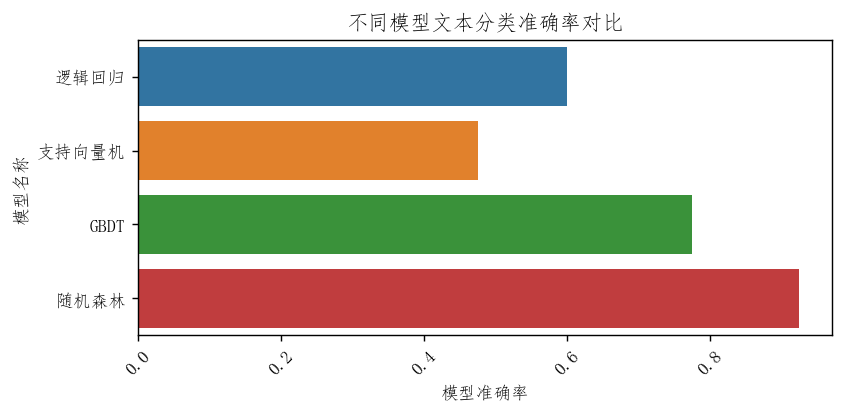

In [45]:

plt.figure(figsize=(7,3),dpi=128)
sns.barplot(y=model_name,x=accuracys,orient="h")
plt.xlabel('模型准确率')
plt.ylabel('模型名称')
plt.xticks(fontsize=10,rotation=45)
plt.title("不同模型文本分类准确率对比")
plt.show()

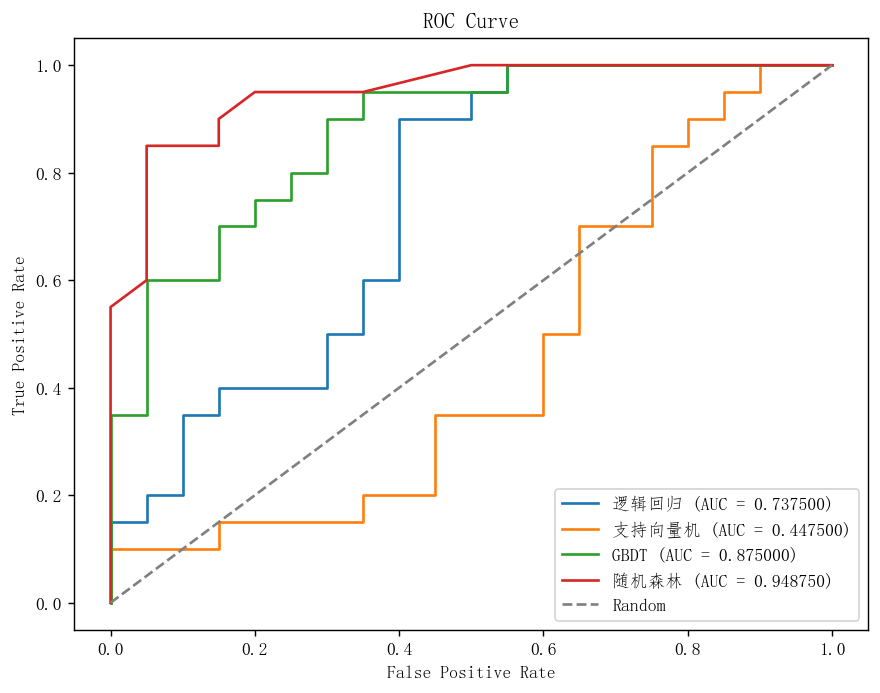

In [32]:
plt.figure(figsize=(8, 6),dpi=128)
 
# 遍历每个模型，绘制其 ROC 曲线
for model, name in zip(model_list, model_name):
    model.fit(X_train, y_train)  # 训练模型
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])  # 计算 ROC 曲线的参数
    roc_auc = auc(fpr, tpr)  # 计算 AUC
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.6f})')  # 绘制 ROC 曲线

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
# 设置图形属性
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### 超参数调优与交叉验证

#### 交叉验证

In [31]:
def gc_skf(model,name):
    skf = StratifiedKFold(n_splits=5,shuffle=True)
    accuracys_mean = []
    # X is the feature set and y is the target
    for train_index, test_index in skf.split(X_classification,y_classification): 
        #print("Train:", train_index, "Validation:", test_index) 
        X_train, X_test = X_classification[train_index], X_classification[test_index] 
        y_train, y_test = y_classification[train_index], y_classification[test_index]
        scores = cross_val_score(model,X_classification,y_classification,cv=skf)
    print(name)
    print("straitified cross validation scores:{}".format(scores))
    print("Mean score of straitified cross validation:{:.2f}".format(scores.mean()))
    accuracys_mean.append(scores.mean())

for model,name in zip(model_list,model_name):
    gc_skf(model,name)

逻辑回归
straitified cross validation scores:[0.575 0.575 0.475 0.575 0.675]
Mean score of straitified cross validation:0.57
支持向量机
straitified cross validation scores:[0.425 0.425 0.6   0.35  0.4  ]
Mean score of straitified cross validation:0.44
GBDT
straitified cross validation scores:[0.775 0.7   0.725 0.725 0.875]
Mean score of straitified cross validation:0.76
随机森林
straitified cross validation scores:[0.8   0.875 0.85  0.8   0.9  ]
Mean score of straitified cross validation:0.85


#### 使用网格搜索进行超参数调优

In [ ]:
from sklearn.model_selection import GridSearchCV

def gc_model(model,param,name):
    gc_search = GridSearchCV(model,param_grid = param,cv = 5)
    gc = gc_search.fit(X_classification,y_classification)
    print(name,'最佳效果：%0.3f' % gc_search.best_score_)
    best_parameters= gc_search.best_estimator_.get_params()
    print(name,'最佳参数：\n', best_parameters)
    return best_parameters


model_param = [
    {'penalty': ['l1','l2'], 'C': [0.01,0.05,0.1,1,10],"solver":['lbfgs','sag','liblinear','newton_cg'],"random_state":[0.42,2024,77]}, 
     #逻辑回归的超参数
    {"C": [0.1, 1, 10, 100],"gamma": [0.001, 0.01, 0.1, 1]},
    #支持向量机的超参数范围
    {
    'learning_rate':[0.01,0.1,0.2],
    'n_estimators': [i for i in range(100,201,10)],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split':[2,4,6,8,10]
    },#GBDT的超参数范围
    {  
    'n_estimators': [i for i in range(1,201,10)]  ,
     'max_features':range(1,21,1)
    }#随机森林的超参数范围  
]


for model, param ,name in zip(model_list, model_param,model_name):
    gc_model(model,param,name)

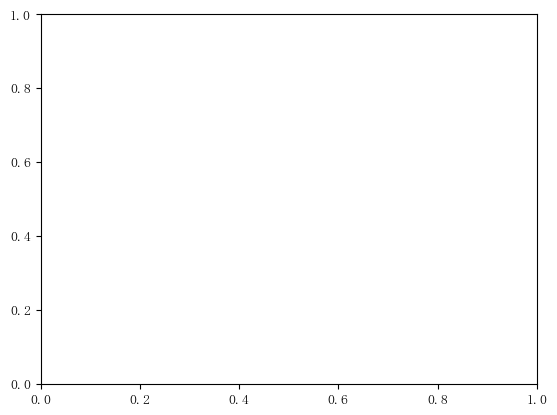

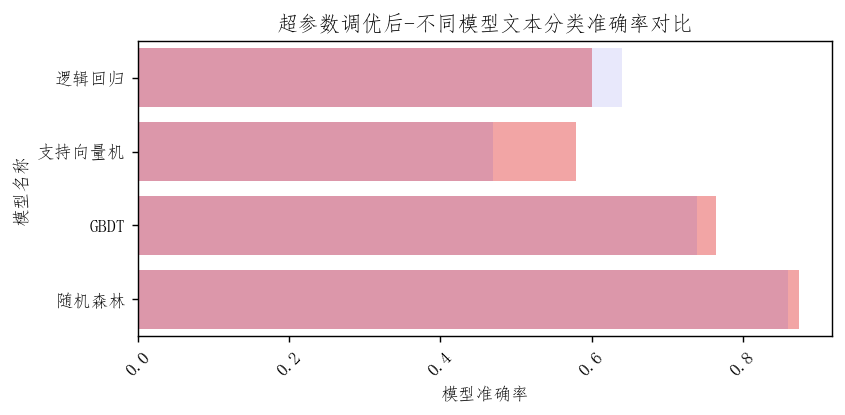

In [44]:
ax = plt.subplots()
#plt.figure(figsize=(7,3),dpi=128)
ax = sns.barplot(y=model_name,x=[0.6,0.58,0.765,0.875], color='r',alpha = 0.4)
ax = sns.barplot(y=model_name,x=[0.64,0.47,0.74,0.86], color='b',alpha = 0.1)
#sns.barplot(y=model_name,x=accuracys,orient="h")

plt.xlabel('模型准确率')
plt.ylabel('模型名称')
plt.xticks(fontsize=10,rotation=45)
plt.title("超参数调优后-不同模型文本分类准确率对比")
plt.show()